# Benchmark Analysis - H2

In [2]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [4]:
matplotlib.style.use('seaborn-v0_8')  

In [5]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M_WITH_BYTES'

In [6]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [7]:
plot_save_dir = './plots/h2'

## Utils 

In [8]:
def get_path(*entries):
    return os.path.join(*entries)

In [9]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [10]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [11]:
def extraction_pandas_frame_algo(path, COMP="TODO"):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [12]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [13]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [14]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

# H2
> The performance is significantly impacted by the order in which parallelism is applied, whether it is outer loop
> sequential and inner loop parallel, or outer loop parallel and inner loop sequential.

## Time 

## `b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par` vs `b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq`

### Time Comparison - `b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par` vs `b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq`


Check how the runtime without constraining the threads develops with increasing input size

In [15]:
def get_b1_2_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    ## load b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par
    b1_2_for_each_quadratic_seq_par = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par__Default.csv',COMP=compiler_name)

    b1_2_for_each_quadratic_seq_par = b1_2_for_each_quadratic_seq_par.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    b1_2_for_each_quadratic_seq_par = b1_2_for_each_quadratic_seq_par.rename(columns={'real_time':f'{compiler_name} - seq_par'})

    ## load b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq
    b1_2_for_each_quadratic_par_seq = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq__Default.csv',COMP=compiler_name)

    b1_2_for_each_quadratic_par_seq = b1_2_for_each_quadratic_par_seq.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    b1_2_for_each_quadratic_par_seq = b1_2_for_each_quadratic_par_seq.rename(columns={'real_time':f'{compiler_name} - par_seq'})

    ## merge 
    return pd.merge(b1_2_for_each_quadratic_seq_par,b1_2_for_each_quadratic_par_seq, on='n')
    


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b1_2_data_algo(*x) for x in instances]


# merge for plotting 
b1_2_for_each_quadratic_time_merged = pd.merge(*data, on='n')

# convert time from ns to microseconds because otherwise it will look really bad
for _, compiler_name in instances:
    b1_2_for_each_quadratic_time_merged[f'{compiler_name} - par_seq'] = b1_2_for_each_quadratic_time_merged[f'{compiler_name} - par_seq'] / 1_000
    b1_2_for_each_quadratic_time_merged[f'{compiler_name} - seq_par'] = b1_2_for_each_quadratic_time_merged[f'{compiler_name} - seq_par'] / 1_000
    

b1_2_for_each_quadratic_time_merged

,GCC(TBB) - seq_par,n,GCC(TBB) - par_seq,NVC(OMP) - seq_par,NVC(OMP) - par_seq
0,597.915,32,29.7379,390.190,14.5394
1,1523.470,64,28.0811,720.989,12.8606
2,3245.270,128,41.7341,1347.420,15.8751
3,7048.390,256,79.8086,2493.740,30.2817
4,16432.600,512,216.5400,5442.830,93.1380
5,37083.500,1024,718.8040,11240.200,323.4780
6,84375.000,2048,2691.9400,22969.700,1262.4300
7,198067.000,4096,10488.2000,49045.400,5020.8600
8,445791.000,8192,41259.5000,110225.000,20008.7000
9,1047380.000,16384,164313.0000,264715.000,79886.7000


### Strong Scaling - `b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par` vs `b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq`
 
1 Million fixed input size with threads 1-64

In [16]:
def get_b1_2_strong_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:

    ## seq base
    seq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_seq__Default.csv',COMP=compiler_name)

    ## Threading data
    b1_2_for_each_quadratic_seq_par_threads = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                                                                    'b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par',
                                                                                    [1,2,4,8,16,32,64],
                                                                                    COMP=compiler_name,
                                                                                    input_size=32768
                                                                                )
    

    ## calc strong scaling
    b1_2_for_each_quadratic_seq_par_strong_scaling = calc_speedup_based_seq(seq_base,
                                                                            b1_2_for_each_quadratic_seq_par_threads,
                                                                            f"{compiler_name} - seq_par",
                                                                            input_size=32768
                                                                        )


    ## load b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq
    b1_2_for_each_quadratic_par_seq_threads = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                                                                    'b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq',
                                                                                    [1,2,4,8,16,32,64],
                                                                                    COMP=compiler_name,
                                                                                    input_size=32768
                                                                                )

    ## calc strong scaling
    b1_2_for_each_quadratic_par_seq_strong_scaling = calc_speedup_based_seq(seq_base,
                                                                            b1_2_for_each_quadratic_par_seq_threads,
                                                                            f"{compiler_name} - par_seq",
                                                                            input_size=32768
                                                                        )

    ## merge
    return pd.merge(b1_2_for_each_quadratic_seq_par_strong_scaling,
                    b1_2_for_each_quadratic_par_seq_strong_scaling, 
                    on='threads'
                )


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b1_2_strong_scaling_algo(*x) for x in instances]

b1_2_for_each_quadratic_strong_scaling_merged = pd.merge(*data, on='threads')

b1_2_for_each_quadratic_strong_scaling_merged


,threads,GCC(TBB) - seq_par,GCC(TBB) - par_seq,NVC(OMP) - seq_par,NVC(OMP) - par_seq
0,1,0.871753,1.000338,0.968989,1.003773
1,2,1.717407,1.995622,1.912243,2.006111
2,4,3.260221,3.990761,3.729022,3.998786
3,8,5.335299,7.934114,6.907830,7.919288
4,16,8.241423,15.690946,11.449122,15.340164
5,32,10.550077,26.926033,15.022925,25.114543
6,64,13.015188,48.584507,14.098456,48.683725


In [17]:
## efficiency graph

b1_2_for_each_quadratic_efficiency = b1_2_for_each_quadratic_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b1_2_for_each_quadratic_efficiency[f'{compiler_name} - par_seq'] = b1_2_for_each_quadratic_efficiency[f'{compiler_name} - par_seq'] / b1_2_for_each_quadratic_efficiency['threads']
    b1_2_for_each_quadratic_efficiency[f'{compiler_name} - seq_par'] = b1_2_for_each_quadratic_efficiency[f'{compiler_name} - seq_par'] / b1_2_for_each_quadratic_efficiency['threads']


b1_2_for_each_quadratic_efficiency

,threads,GCC(TBB) - seq_par,GCC(TBB) - par_seq,NVC(OMP) - seq_par,NVC(OMP) - par_seq
0,1,0.871753,1.000338,0.968989,1.003773
1,2,0.858703,0.997811,0.956122,1.003056
2,4,0.815055,0.997690,0.932256,0.999697
3,8,0.666912,0.991764,0.863479,0.989911
4,16,0.515089,0.980684,0.715570,0.958760
5,32,0.329690,0.841439,0.469466,0.784829
6,64,0.203362,0.759133,0.220288,0.760683


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_19755/4131775186.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


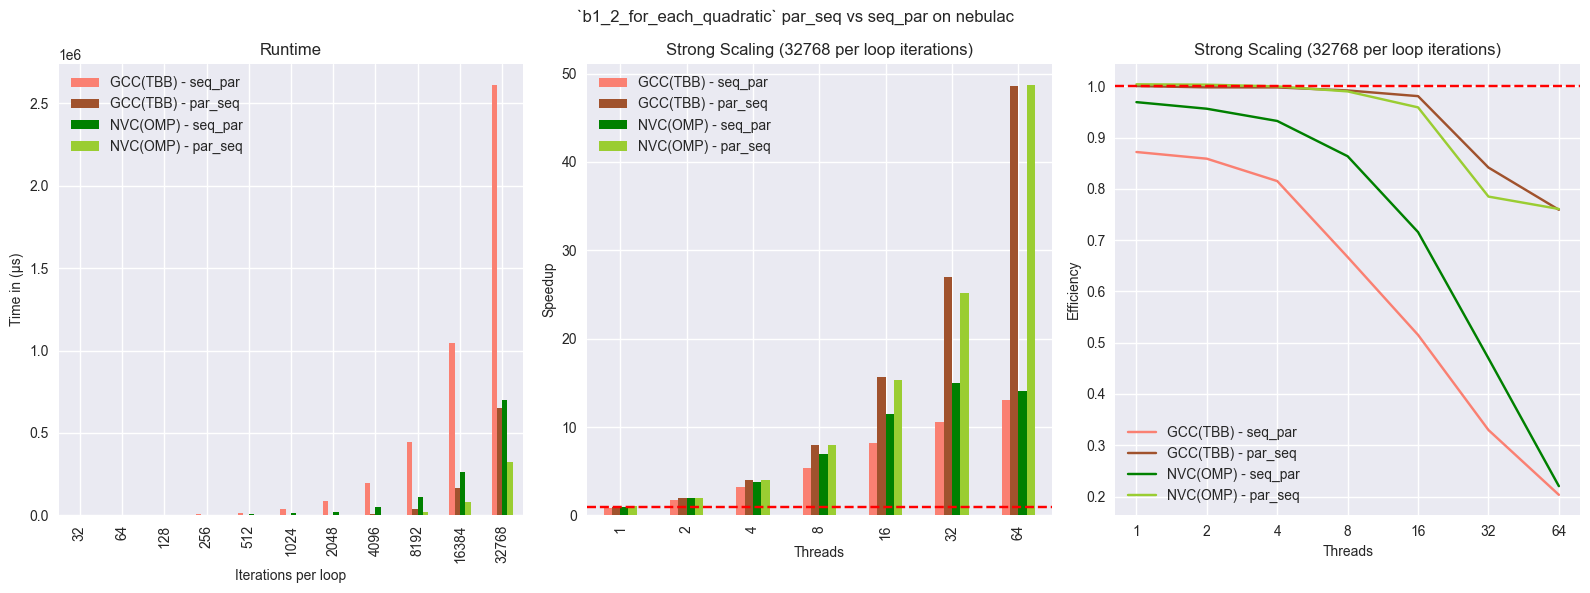

In [18]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# runtime
ax_1 = b1_2_for_each_quadratic_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],ax=axes[0])


#plt.yscale('log', base=10)
ax_1.set_ylabel('Time in (µs)')
ax_1.set_xlabel('Iterations per loop')
ax_1.set_title('Runtime')



# plot strong scaling
ax_2 = b1_2_for_each_quadratic_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                        ax=axes[1]
                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')


ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling (32768 per loop iterations)')





# plot efficiency
ax_3 = b1_2_for_each_quadratic_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                             ax=axes[2]
                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

#plt.ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Strong Scaling (32768 per loop iterations)')


fig.suptitle("`b1_2_for_each_quadratic` par_seq vs seq_par on nebulac")

fig.tight_layout()

plot("`b1_2_for_each_quadratic` par_seq vs seq_par on nebulac")

## Performance Portability Calculation (Inter Compiler)

Since we know that (par, seq) will be better than (seq,par) we can check the stddev of the performance improvement
from (seq, par) to (par,seq) for every compiler. For example:

```
  |          | (seq,par) | (par,seq) | faster |
  |----------|-----------|-----------|--------|
  | GCC(TBB) | 10s       | 5s        | 2x     |
  | NVC(OMP) | 12s       | 8s        | 1.5x   |
  | NVC(GPU) | 0         | 0         | 0      |
  | Intel    | 9         | 1         | 9x     |
```

stddev(2,1.5,9) = 3.4 indicating that the difference is quite significant when changing compilers.

stddev(2,1.5) = 0.25 indicating that the difference is not significant when changing compilers.

In [19]:
# calc pp_metrics

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

faster_data = []

for compiler_location, compiler_name in instances:
    print(compiler_name)

    times_faster = (b1_2_for_each_quadratic_time_merged[f'{compiler_name} - seq_par'] / b1_2_for_each_quadratic_time_merged[f'{compiler_name} - par_seq']).iloc[-1]
    faster_data.append(times_faster)

    print("\t Par_Seq faster than Seq_Par: ", times_faster)
    print()
    

print("\n")
pp_h2 = statistics.stdev(faster_data)

print("Performance Portability H2:",pp_h2)

GCC(TBB)
	 Par_Seq faster than Seq_Par:  3.9916563313855598

NVC(OMP)
	 Par_Seq faster than Seq_Par:  2.1852225997059564



Performance Portability H2: 1.2773415414347677


## Findings for H2

### `b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par` (seq_par)

The performance of seq_par exhibits significant variations when switching between compilers, particularly for larger input sizes of 8192+. The runtime differences become increasingly worse, and GCC(TBB) demonstrates poor performance in such scenarios.

As for strong scaling, seq_par's performance is rather poor. Both GCC(TBB) and NVC(OMP) experience a poor speedup after 16 threads. While GCC(TBB) exhibits minor improvements with additional threads, they are insignificant. On the other hand NVC(OMP) loses speedup once 64 threads are used. The efficiency graph shows that NVC(OMP) takes a hit at 8 threads, with both collapsing at 16 threads. Notably, NVC(OMP) starts from a higher efficiency level than GCC(TBB).

Key Observations: 
* Runtime of seq_par changes a lot from compiler to compiler
* GCC(TBB) performs really bad (runtime)
* Strong scaling of GCC(TBB) is better than NVC(OMP)
* NVC(OMP) strong scaling even worse when going 32->64 threads

### `b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq` (par_seq)

We see the same behaviour here as seen when using seq_par.  Notably, as the input sizes increase, GCC(TBB) shows a more rapid decline in performance compared to NVC(OMP). For instance, when transitioning from 16k to 32k, NVC(OMP) experiences a speedup of `2.89x`, whereas GCC(TBB) only shows a speedup of `3.98x`.

Moreover, the two backends exhibit different behavior when strong scaling. As the number of threads increases, GCC(TBB) benefits from the added resources, while NVC(OMP) takes a considerable hit and reaches peak performance at 32 threads.

Key Observations:
* Runtime difference  visible (when changing compiler)
* GCC(TBB) runtime explodes for large input size 
* NVC(OMP) runtime rises as exepcted for large input sizes
* GCC(TBB) strong scaling way better than NVC(OMP)
* NVC(OMP) strong scaling starts to slow down at 32 threads

## General

We can observe a significant difference in runtime when we switch between execution policies for inner and outer loops. This behavior is consistent across all parallel backends. In terms of runtime, GCC(TBB) shows the most substantial improvement when switching from seq_par to par_seq. However, NVC(OMP) performs better in absolute runtime numbers.

Switching from seq_par to par_seq also affects strong scaling. For smaller input sizes, the backends show similar strong scaling behavior. However, for larger thread counts (64), GCC(TBB) still shows improvements over NVC(OMP).

When switching between backends, all of them show improvement, though to varying degrees. The extent of improvement differs between the backends, as reflected in the performance portability metric calculated for this benchmark. The stddev value of 0.71 indicates that changing compilers can lead to better performance improvements.

Key Observation: 
* Changing order of execution policiy has great impact.
* Strong Scaling varies a lot by compiler 
* Absolute Runtime difference by compiler is a lot
* Improvement from seq_par to par_seq varies significantly by compiler 

### GPU Findings

Sadly because this benchmarks use nested parallelism it wont work on the NVC(GPU).


## Hypothesis Findings

This is hypothesis is **TRUE**! 

